# Statistiche per Nerd homebrew

In [1]:
import schedule
import signal
import json
import time
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as ec
from IPython.display import display, display_html, DisplayHandle, Image

In [2]:
def interrupt_handler(signum, driver: webdriver.Chrome):
    print(f'Handling signal {signum} ({signal.Signals(signum).name}).')

    schedule.clear()
    driver.quit()
    %reset_selective -f driver
    raise SystemExit

In [3]:
def setupChromeDriver():
    chrome_options = Options()
    #chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1280,720")
    chrome_options.add_argument("--mute-audio")
    driver = webdriver.Chrome(options=chrome_options)
    return driver

In [4]:
def saveStats(stats):

    with open('stats.json', 'r+') as jsonFile:
        try:
            data = json.load(jsonFile)
        except json.JSONDecodeError:
            data = []
        data.append(stats)
        jsonFile.seek(0)
        json.dump(data, jsonFile, indent=4)

def downloadStats(driver: webdriver.Chrome, display_handle: DisplayHandle):
    html = driver.find_element(By.CLASS_NAME ,'vjs-stats-list')
    htmlBS = bs(html.get_attribute('innerHTML'), 'html.parser')

    timestampDiv = htmlBS.new_tag('div', attrs={'style': 'display: block;'})
    timestampTitleDiv = htmlBS.new_tag('div')
    timestampTitleDiv.string = 'Timestamp'
    timestampDiv.append(timestampTitleDiv)
    timestampSpan = htmlBS.new_tag('span')
    timestampSpan.string = time.strftime('%Y-%m-%dT%H:%M:%S%z')
    timestampDiv.append(timestampSpan)
    htmlBS.div.insert_before(timestampDiv)
    
    stats = htmlBS.find_all('div', attrs={'style': 'display: block;'})
    statsList = dict(
        map(
            lambda stat: (
                stat.div.text, 
                stat.span.text.replace('\u21d3', 'down').replace('down/', 'down /').replace('\u21d1 ', 'up').replace('\u21d1', 'up').replace('\u00b7', '-').strip()
            ), stats
        )
    )

    display_handle.update(statsList)

    saveStats(statsList)

In [5]:
def setupStats(driver: webdriver.Chrome, url: str):
    actions = ActionChains(driver)
    wait = WebDriverWait(driver, 30, poll_frequency=0.2)

    driver.get(url)

    wait.until(ec.presence_of_element_located((By.CLASS_NAME, 'vjs-big-play-button')))
    actions.click(driver.find_element(By.CLASS_NAME ,'video-js')).perform()
    actions.context_click(driver.find_element(By.CLASS_NAME ,'video-js')).perform()
    statsForNerds = driver.find_elements(By.CLASS_NAME ,'vjs-menu-item')
    actions.pause(1)
    actions.click(statsForNerds[-1]).perform()
    wait.until(ec.text_to_be_present_in_element((By.CLASS_NAME, 'vjs-stats-list'), 'Player'))

    display(Image(driver.get_screenshot_as_png()))

    return driver

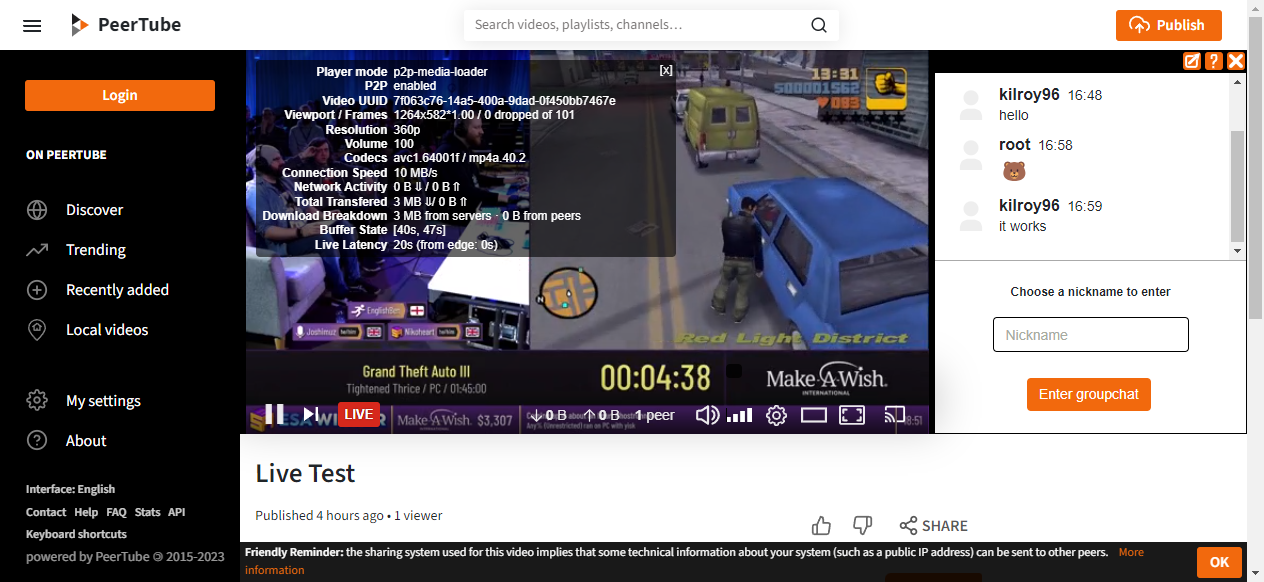

{'Timestamp': '2024-03-07T03:08:51+0100',
 'Player mode': 'p2p-media-loader',
 'P2P': 'enabled',
 'Video UUID': '7f063c76-14a5-400a-9dad-0f450bb7467e',
 'Viewport / Frames': '1264x582*1.00 / 3 dropped of 5465',
 'Resolution': '720p',
 'Volume': '100',
 'Codecs': 'avc1.640020 / mp4a.40.2',
 'Connection Speed': '6 MB/s',
 'Network Activity': '2 MB down / 0 B up',
 'Total Transfered': '49 MB down / 0 B up',
 'Download Breakdown': '49 MB from servers - 0 B from peers',
 'Buffer State': '[40s, 2m23s]',
 'Live Latency': '20s (from edge: 0s)'}

Handling signal 2 (SIGINT).


SystemExit: 

c:\Users\mirko\statnerd\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
if __name__ == '__main__':
    driver = setupChromeDriver()

    signal.signal(signal.SIGINT, lambda signum, frame: interrupt_handler(signum, driver))
    
    setupStats(driver, "https://tube.kobim.cloud/w/gFL48Fz3doCEnYwK46BwYN")

    display_handle = display("Loading...", display_id=True)
    
    schedule.every(0.3).seconds.do(downloadStats, driver, display_handle)
    while True:
        schedule.run_pending()